# 4. Model — UK Electricity Demand
**Worked on by:** Marin Janushaj  
**Goal:** Build a time-aware regression model to forecast electricity demand using historical patterns.

In [10]:
import pandas as pd
from pathlib import Path

data_path = Path("../data/clean/uk_electricity_hourly.parquet")
df = pd.read_parquet(data_path)
df = df.reset_index().rename(columns={"index": "timestamp"})  # if index was unnamed
df["hour"] = pd.to_datetime(df["timestamp"]).dt.hour
df["day"] = pd.to_datetime(df["timestamp"]).dt.day
df["month"] = pd.to_datetime(df["timestamp"]).dt.month
df["weekday"] = pd.to_datetime(df["timestamp"]).dt.weekday
df["is_weekend"] = (df["weekday"] >= 5).astype(int)

df.head()

,timestamp,demand_mw,hour,day,month,weekday,is_weekend
0,2001-01-01 00:00:00,37761.000000,0,1,1,0,0
1,2001-01-01 01:00:00,38109.083333,1,1,1,0,0
2,2001-01-01 02:00:00,38457.166667,2,1,1,0,0
3,2001-01-01 03:00:00,38805.250000,3,1,1,0,0
4,2001-01-02 00:00:00,46115.000000,0,2,1,1,0


In [12]:
from pycaret.regression import *

s = setup(
    data=df,
    target="demand_mw",
    ignore_features=["timestamp"],
    session_id=42,
    train_size=0.9,
    normalize=True,
    verbose=True
)

best = compare_models(sort="MAE")
final_model = finalize_model(best)
save_model(final_model, "../data/clean/electricity_model")

,Description,Value
0,Session id,42
1,Target,demand_mw
2,Target type,Regression
3,Original data shape,"(34755, 7)"
4,Transformed data shape,"(34755, 6)"
5,Transformed train set shape,"(31279, 6)"
6,Transformed test set shape,"(3476, 6)"
7,Ignore features,1
8,Numeric features,5
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,4793.7903,31793032.0519,5638.2610,0.4426,0.1790,0.1549,0.2220
gbr,Gradient Boosting Regressor,4862.1348,32710313.5316,5719.0675,0.4265,0.1813,0.1570,0.1580
ada,AdaBoost Regressor,5131.8661,36332852.4214,6027.4970,0.3630,0.1872,0.1610,0.0650
knn,K Neighbors Regressor,5414.9596,41619392.4000,6450.8336,0.2703,0.2022,0.1740,0.0120
rf,Random Forest Regressor,5743.2768,48722432.0205,6979.3867,0.1459,0.2182,0.1847,0.3710
par,Passive Aggressive Regressor,5829.2379,53221574.6393,7294.9881,0.0669,0.2274,0.1906,0.0090
huber,Huber Regressor,5838.4782,52995455.6181,7279.5155,0.0709,0.2259,0.1890,0.0130
lar,Least Angle Regression,5841.6883,52972196.9255,7277.9306,0.0713,0.2260,0.1892,0.0060
lr,Linear Regression,5841.6883,52972196.9255,7277.9306,0.0713,0.2260,0.1892,0.3960
ridge,Ridge Regression,5841.6907,52972195.7620,7277.9305,0.0713,0.2260,0.1892,0.0060


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['hour', 'day', 'month', 'weekday',
                                              'is_weekend'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('normalize', TransformerWrapper(transformer=StandardScaler())),
                 ('actual_estimator',
                  LGBMRegressor(n_jobs=-1, random_state=42))]),
 '../data/clean/electricity_model.pkl')

In [13]:
import pandas as pd

# last known timestamp
last_ts = pd.to_datetime(df["timestamp"]).max()

# create next 24 hourly timestamps
future_ts = pd.date_range(last_ts + pd.Timedelta(hours=1), periods=24, freq="H")

# build feature frame for those timestamps
future = pd.DataFrame({"timestamp": future_ts})
future["hour"] = future["timestamp"].dt.hour
future["day"] = future["timestamp"].dt.day
future["month"] = future["timestamp"].dt.month
future["weekday"] = future["timestamp"].dt.weekday
future["is_weekend"] = (future["weekday"] >= 5).astype(int)

In [14]:
pred = predict_model(final_model, data=future.copy())

pred_col = "prediction_label" if "prediction_label" in pred.columns else "Label"
out = pred[["timestamp", pred_col]].rename(columns={pred_col: "forecast_mw"})

out.head()

,timestamp,forecast_mw
0,2025-10-16 01:00:00,35979.168575
1,2025-10-16 02:00:00,35928.609453
2,2025-10-16 03:00:00,35928.609453
3,2025-10-16 04:00:00,35928.609453
4,2025-10-16 05:00:00,35928.609453


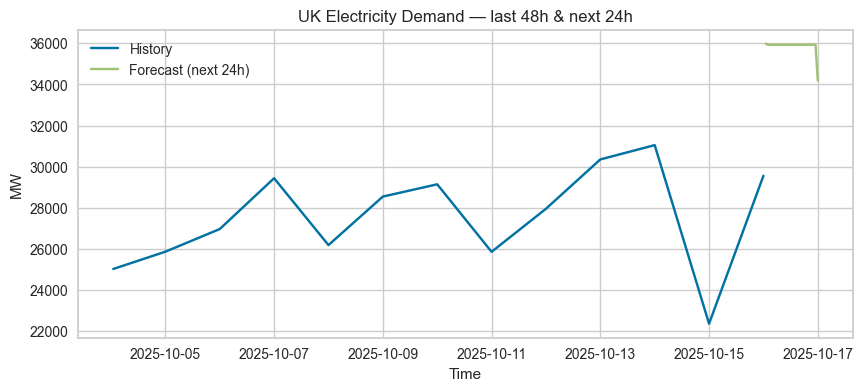

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(pd.to_datetime(df["timestamp"]).tail(48), df["demand_mw"].tail(48), label="History")
plt.plot(out["timestamp"], out["forecast_mw"], label="Forecast (next 24h)")
plt.title("UK Electricity Demand — last 48h & next 24h")
plt.xlabel("Time"); plt.ylabel("MW"); plt.grid(True); plt.legend(); plt.show()